In [2]:
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("df_final.csv")

In [4]:
df.head()

,business_stars_rating,total_hours,business_review_count,parking_available,BikeParking,is_open,validated,Fitness & Active Life,Other,Religious Organizations,Restaurants & Beverages,BusinessParking
0,0.927672,1.720611,0,1,0,1,1,0,1,0,0,1
1,0.414114,2.079852,0,1,1,1,1,0,1,0,0,1
2,-1.640120,-1.063511,0,0,0,0,0,0,1,0,0,0
3,0.927672,-1.063511,0,1,1,1,1,0,1,0,0,1
4,1.441231,-0.255217,0,0,0,1,0,0,1,0,0,0


In [5]:
df.shape

(150346, 12)

In [6]:
df['BusinessParking'].value_counts()

BusinessParking
0    89489
1    60857
Name: count, dtype: int64

In [7]:
df.columns

Index(['business_stars_rating', 'total_hours', 'business_review_count',
       'parking_available', 'BikeParking', 'is_open', 'validated',
       'Fitness & Active Life', 'Other', 'Religious Organizations',
       'Restaurants & Beverages', 'BusinessParking'],
      dtype='object')

In [8]:

X = df.drop("BusinessParking", axis=1)  # Features
y = df["BusinessParking"]  # Target (Anomalies)


In [9]:
y.head()

0    1
1    1
2    0
3    1
4    0
Name: BusinessParking, dtype: int64

In [10]:
# Splitting the dataset into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
# Check the shapes to verify the split
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (105242, 11)
X_test shape: (45104, 11)
y_train shape: (105242,)
y_test shape: (45104,)


In [12]:
# Filter X_train to include only data points where y_train == 0
normal_class_label = 0
X_train_normal = X_train[y_train == normal_class_label]


In [12]:
from sklearn.preprocessing import StandardScaler

# Scale only the normal class data
scaler = StandardScaler()
X_train_normal_scaled = scaler.fit_transform(X_train_normal)

# Scale the entire training set for later predictions
X_train_scaled = scaler.transform(X_train)


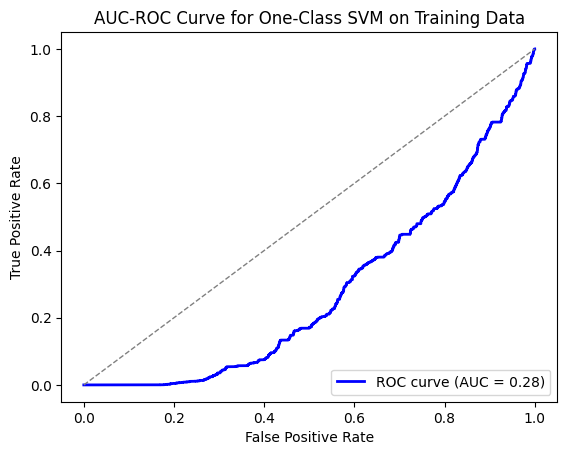

In [13]:
ocsvm = OneClassSVM(kernel="rbf", gamma=0.01, nu=0.05)  # Try different combinations of nu and gamma
ocsvm.fit(X_train_normal)

# Recompute the decision function and binary predictions
y_pred_train = ocsvm.decision_function(X_train)
y_pred_binary = ocsvm.predict(X_train)

# Map the predictions correctly
y_pred_binary_mapped = [0 if pred == 1 else 1 for pred in y_pred_binary]

# Compute and plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_train, y_pred_train)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve for One-Class SVM on Training Data')
plt.legend(loc="lower right")
plt.show()


In [13]:
# Train One-Class SVM on the scaled normal class data
ocsvm = OneClassSVM(kernel="rbf", gamma="auto", nu=0.1) 
ocsvm.fit(X_train_normal_scaled)


OneClassSVM(gamma='auto', nu=0.1)

In [14]:
# Predict on the full training set
y_pred_train = ocsvm.decision_function(X_train_scaled)  # Decision scores for AUC-ROC
y_pred_binary = ocsvm.predict(X_train_scaled)  # Binary predictions: 1 (normal), -1 (anomaly)


In [17]:
# Map the predictions correctly: 1 -> 0 (normal), -1 -> 1 (anomaly)
y_pred_binary_mapped = [0 if pred == 1 else 1 for pred in y_pred_binary]

In [ ]:
eghs

In [20]:
print("Class distribution in y_train:", y_train.value_counts())


Class distribution in y_train: BusinessParking
0    62708
1    42534
Name: count, dtype: int64


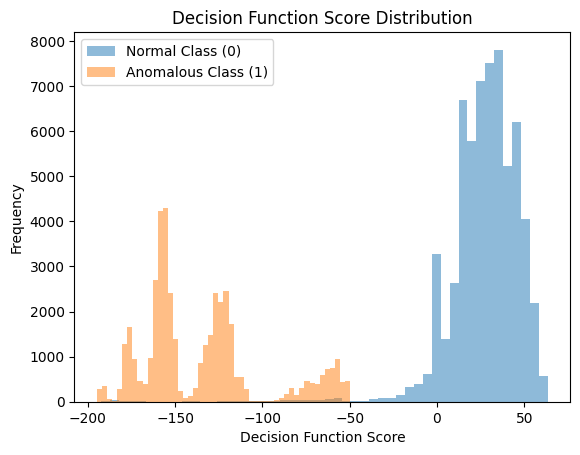

In [23]:
import matplotlib.pyplot as plt

# Visualize the decision function scores (first 1000 samples for clarity)
plt.hist(y_pred_train[y_train == 0], bins=50, alpha=0.5, label='Normal Class (0)')
plt.hist(y_pred_train[y_train == 1], bins=50, alpha=0.5, label='Anomalous Class (1)')
plt.xlabel('Decision Function Score')
plt.ylabel('Frequency')
plt.legend()
plt.title('Decision Function Score Distribution')
plt.show()


In [24]:
# Check the unique values in the binary predictions
print("Unique values in binary predictions:", set(y_pred_binary))  # Should contain 1 and -1 for normal and anomaly
print("First few predicted labels:", y_pred_binary[:10])  # Check the first few predictions

# Check the first few true labels for comparison
print("First few true labels:", y_train[:10])


Unique values in binary predictions: {1, -1}
First few predicted labels: [ 1  1 -1 -1 -1  1  1  1 -1  1]
First few true labels: 46317     0
89562     0
80031     1
103067    1
100781    1
9446      0
33441     0
101061    0
138680    1
135807    0
Name: BusinessParking, dtype: int64


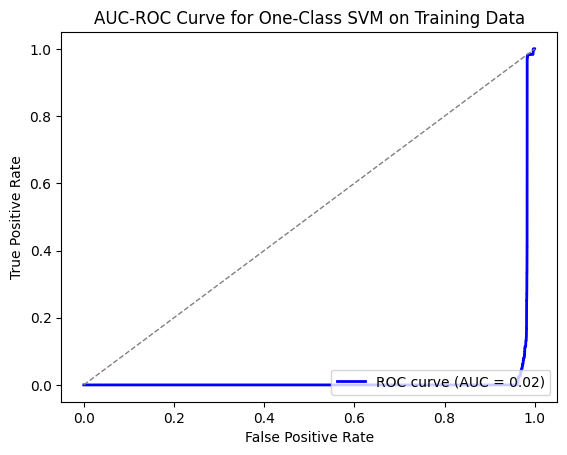

In [ ]:
# Split data into train and test
X_train = X_scaled[y == 0]  # Train only on normal cases
X_test = X_scaled  # Test on the full dataset


In [ ]:
# Step 2: Train One-Class SVM
start_time = time.time()
oc_svm = OneClassSVM(kernel='rbf', nu=0.1, gamma='auto')
oc_svm.fit(X_train)
train_time = time.time() - start_time


In [ ]:
# Step 3: Predictions
oc_train_predictions = oc_svm.predict(X_train)
oc_train_predictions_binary = (oc_train_predictions == -1).astype(int)  # -1 -> anomaly

oc_test_predictions = oc_svm.predict(X_test)
oc_test_predictions_binary = (oc_test_predictions == -1).astype(int)



In [ ]:
# Step 4: AUC Scores
train_auc = roc_auc_score(np.zeros(len(X_train)), oc_train_predictions_binary)  # Train data: All 0s (normal)
test_auc = roc_auc_score(y, oc_test_predictions_binary)  # Test data: Compare with actual labels


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [ ]:
# Step 4: AUC Scores
# Since AUC is not meaningful on training data with one class, evaluate anomaly detection proportion
train_anomaly_fraction = oc_train_predictions_binary.mean()  # Fraction of predicted anomalies in training set
print(f"Anomaly Fraction in Training Data: {train_anomaly_fraction:.2f}")

# Test AUC can be computed as it has both classes
test_auc = roc_auc_score(y, oc_test_predictions_binary)  # Test data: Compare with actual labels
print(f"Test AUC: {test_auc:.2f}")


Anomaly Fraction in Training Data: 0.10
Test AUC: 0.80


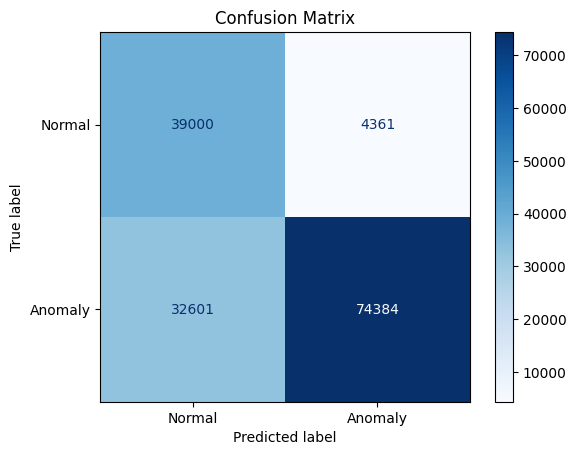

In [ ]:
# Step 5: Confusion Matrix
cm = confusion_matrix(y, oc_test_predictions_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Step 7: Output Results
print("One-Class SVM Classification Report:")
print(classification_report(y, oc_test_predictions_binary))
print(f"Train Time: {train_time:.2f} seconds")

print(f"Test AUC: {test_auc:.2f}")


One-Class SVM Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.90      0.68     43361
           1       0.94      0.70      0.80    106985

    accuracy                           0.75    150346
   macro avg       0.74      0.80      0.74    150346
weighted avg       0.83      0.75      0.77    150346

Train Time: 7.79 seconds
Test AUC: 0.80


In [ ]:
test_auc = roc_auc_score(y, oc_test_predictions_binary)

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Step 4: Compute ROC Curve and AUC for Test Data
fpr, tpr, thresholds = roc_curve(y, oc_test_predictions_binary)
roc_auc = auc(fpr, tpr)

# Step 5: Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


NameError: name 'oc_test_predictions_binary' is not defined

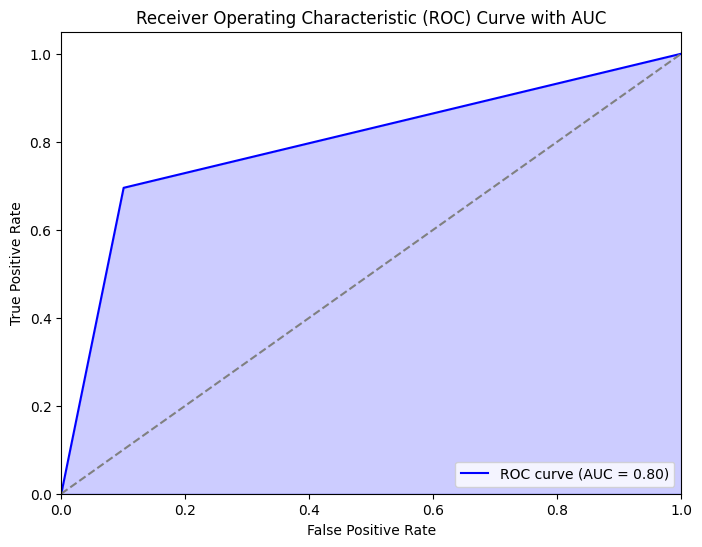

In [ ]:
# Step 5: Plot ROC Curve and Highlight AUC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.fill_between(fpr, tpr, alpha=0.2, color='blue')  # Shade the area under the curve
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve with AUC')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Count the number of outliers in the predictions
number_of_outliers = np.sum(oc_test_predictions_binary)
print(f"Number of Outliers Detected: {number_of_outliers}")


Number of Outliers Detected: 78745


## Lime

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

# Initialize LIME with regression mode
explainer = LimeTabularExplainer(
    X_scaled,
    feature_names=X.columns,
    mode="regression"  # Use regression mode for continuous outputs
)



In [ ]:
# Select an instance to explain
instance = X_scaled[1]  # Example instance

# Explain the prediction using the decision function
explanation = explainer.explain_instance(instance, oc_svm.decision_function)

# Show explanation in a notebook or as text
explanation.show_in_notebook(show_table=True)
